# Building Lola the NYC Subway Bot

Our team wanted to create a data product that would
be useful to New Yorkers like ourselves in every day life.

By creating a Facebook messenger bot we could create
a product that would be easily accessible and tell
people what they really want to know — if the subway
line they have to take is running on time or is going to
make their life harder.

<font color='red'> Since the bot runs on one script (attached to assignment), running all cells in this notebook may result in errors. </font>

## 1 - Web Crawling

To start, we crawl subway information from subwaystats.com, which pulls information from the MTA data feed. The output is a dictionary with each subway line, its status, and its uptime.

In [1]:
import requests # necessary to fetch URLs
from lxml import html # for parsing the returned HTML/XML
import pandas # To create a dataframe
import datetime

url = "http://subwaystats.com/"
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.1 Safari/537.36'}

response = requests.get(url, headers=headers)
doc = html.fromstring(response.text) # parse it and create a document

rows = doc.xpath("//tbody/tr")

def extract_status(status):
    x = status[10:]
    y = x[:-7]
    return y

import re 

def extract_uptime(uptime):
    regex_expression = '\d{1,3}'
    regex= re.compile(regex_expression)
    matches = regex.finditer(uptime)
    for m in matches: 
        return int(m.group())
        

#define a function that creates a list of dictionaries, each dictionary containing row content
def getSubwayInfo(row):
    status_raw = row.xpath('./td/div[@class="statusHome"]')[0].text_content()
    line = row.xpath('./th//div')[0].text_content()
    uptime_raw = row.xpath('./td/div/div[@class="progress-bar"]/span[@class="sr-only"]')[0].text_content()
    status = extract_status(status_raw)
    uptime = extract_uptime(uptime_raw)

    result = {
        "line": line,
        "status" : status, 
        "uptime": uptime
    }
    return result

subway_updates = [getSubwayInfo(row) for row in rows]

In [2]:
subway_updates

[{'line': '1', 'status': 'Good Service', 'uptime': 38},
 {'line': '2', 'status': 'Good Service', 'uptime': 40},
 {'line': '3', 'status': 'Good Service', 'uptime': 39},
 {'line': '4', 'status': 'Good Service', 'uptime': 58},
 {'line': '5', 'status': 'Good Service', 'uptime': 85},
 {'line': '6', 'status': 'Good Service', 'uptime': 74},
 {'line': '7', 'status': 'Delays', 'uptime': 88},
 {'line': 'A', 'status': 'Good Service', 'uptime': 67},
 {'line': 'C', 'status': 'Good Service', 'uptime': 88},
 {'line': 'E', 'status': 'Good Service', 'uptime': 67},
 {'line': 'B', 'status': 'Delays', 'uptime': 60},
 {'line': 'D', 'status': 'Delays', 'uptime': 27},
 {'line': 'F', 'status': 'Delays', 'uptime': 23},
 {'line': 'M', 'status': 'Delays', 'uptime': 63},
 {'line': 'G', 'status': 'Delays', 'uptime': 44},
 {'line': 'J', 'status': 'Good Service', 'uptime': 73},
 {'line': 'Z', 'status': 'Good Service', 'uptime': 100},
 {'line': 'L', 'status': 'Good Service', 'uptime': 96},
 {'line': 'N', 'status': 'G

## 2 - Creating a MySQL DataBase

Next we generate a MySQL database to store the information as the scraper runs on 5 minute intervals.

In [ ]:
#to insert data into MySQL
import MySQLdb as mdb
import sys
import datetime

con = mdb.connect(host = 'localhost', 
                  user = 'root', 
                  passwd = 'dwdstudent2015', 
                  charset='utf8', use_unicode=True);

#create database
db_name = 'mta2'
create_db_query = "CREATE DATABASE IF NOT EXISTS {db} DEFAULT CHARACTER SET 'utf8'".format(db=db_name)

cursor = con.cursor()
cursor.execute(create_db_query)
cursor.close()

#to create a table
cursor = con.cursor()
db_name = 'mta2'
table_name = 'subway_stats' #created a table called team_stats 

# The {db} and {table} are placeholders for the parameters in the format(....) statement
create_table_query = '''CREATE TABLE IF NOT EXISTS {db}.{table} 
                                (line varchar(250), 
                                status varchar(250), 
                                uptime int,
                                last_update datetime,
                                PRIMARY KEY(line, last_update)
                                )'''.format(db=db_name, table=table_name)
cursor.execute(create_table_query)
cursor.close()

#to insert data
query_template = '''INSERT IGNORE INTO 
    mta2.subway_stats(line, status, uptime, last_update) 
    VALUES (%s, %s, %s, %s)'''

cursor = con.cursor()


for entry in subway_updates:
    line = entry["line"]
    status = entry["status"]
    uptime = entry["uptime"]
    last_update = datetime.datetime.now()
    print("Inserting line", line)
    query_parameters = (line, status, uptime, last_update)
    cursor.execute(query_template, query_parameters)

con.commit()
cursor.close()

## 3 - Launching Flask Server on Heroku

Facebook requires that you set up a Webhook in order to receive requests. Messages sent to the Facebook page are routed to this server, where the bot processes, parses, queries, and responds. 

This is where we run the full script, the following blocks are just meant to illustrate what parts of the script do.

To deploy the full script to Heroku, we issue the following commands from the terminal within our "lola" folder:

```
$ heroku login
$ git add .
$ git commit -am "<whatever change was made>"
$ git push heroku master
```

In [ ]:
application = Flask(__name__)
app = application
PAT = 'EAAa2XBIlumsBAJsTZAPFGAMe24UEW8nhHZBPr0siwtlbdsgybjS0zXZCYrYZCJCdK3hI2EzoH1jmr1kdiRU6pwOfSzOK2INkdEh9S2VZCMXmfXPKKvSoFZCuZA1ZCtNLaQPhBlRh3cfZAOtdSGp7xMa8dpdcWEnP0RUWDnjp5L9ImkQZDZD'
VERIFICATION_TOKEN = 'verify_me'

@app.route('/', methods=['GET'])
def handle_verification():
    print ("Handling Verification.")
    if request.args.get('hub.verify_token', '') == VERIFICATION_TOKEN:
        print ("Webhook verified!")
        return request.args.get('hub.challenge', '')
    else:
        return "Wrong verification token!"

In [ ]:
if __name__ == '__main__':
    if len(sys.argv) == 2: # Allow running on customized ports
        app.run(port=int(sys.argv[1]))
    else:
        app.run() # Default port 5000

## 4 - Bot Fundamentals

The following functions allow the bot to do its thing. The basic process flow is as follows:

User sends message -> message received -> processed (text/audio/location?) -> subway line extracted -> DB searched for latest record -> dynamic response formed -> response sent to user

In [ ]:
def extract_subwayline(message):
    # Extract the line from the user message
    regex_expression = '[\s]+[1234567ACEBDFMGJZLNQRWS][\s]+'
    regex = re.compile(regex_expression,re.IGNORECASE)
    matches = regex.finditer(message)
    for match in matches:
        result = {
            "subway_line": match.group().title()
        }
        subway_line = str(result["subway_line"].strip())
        return subway_line

In [ ]:
def subway_data_message3(subway_line):
    error_message = 'Sorry, can you try to be more clear about which train you need the status of?'
    if subway_line == None: #return error is regex search didn't find a subway line
        return error_message
    elif subway_line != None:
        subwayline = str(subway_line)
        with con:
            cur = con.cursor(mdb.cursors.DictCursor)
            # MySQL query on subway DB
            cur.execute(""" SELECT *
                         FROM subway_stats
                         INNER JOIN (SELECT line, MAX(last_update) as recent FROM subway_stats GROUP BY line) md
                             on md.line = subway_stats.line AND md.recent = subway_stats.last_update
                         WHERE md.line=%s """,subwayline)
            result = list(cur.fetchall())
            cur.close()

            status = result[0]['status']
            uptime = result[0]['uptime']

            # Dynamic response, based on current train status and train line
            t = ' Current uptime for the {sl} train is {u}%'.format(sl=subwayline, u=uptime)

            status1 = 'Good Service'
            status2 = 'Delays'
            status3 = 'Planned Work'
            status4 = 'Service Change'

            L = "Do you live in Brooklyn? Lmao that sucks. "
            W = "OoooOo the W? Do you live in the Upper East Side? Bougie AF. "
            N = "Tryna get to 8th St. - NYU? SMH bunch of bitches down there. "

            if status == status1:
                supertext = "I think you'll have good service. :)" + t
            elif status == status2:
                supertext = "Hope you're not in a rush LOL. We got delays for daysss." + t
            elif status == status3:
                supertext = "Planned work! You should probably check what's up before you leave the house today." + t
            elif status == status4:
                supertext = "Service change! Don't you just love NYC?" + t

            if subwayline == "L":
                return L + supertext
            if subwayline == "W":
                return W + supertext
            if subwayline == "N":
                return N + supertext
            else:
                return supertext

In [ ]:
def handle_messages():
    payload = request.get_data()

    # Handle messages
    for sender_id, message in messaging_events(payload):
        # Start processing valid requests
        try:
            response = processIncoming(sender_id, message)
            message = str(message)
            subway_line = extract_subwayline(message)
            answer = str(subway_data_message3(subway_line))

            if response is not None:
                send_message(PAT, sender_id, answer)

            else:
                send_message(PAT, sender_id, "Sorry I don't understand that")
        except Exception as e:
            print (e)
            traceback.print_exc()
    return "ok"

In [ ]:
def processIncoming(user_id, message):
    if message['type'] == 'text':
        message_text = message['data']
        return message_text

    elif attachment['type'] == 'location':
        response = "I've received location (%s,%s) (y)"%(message['data'][0],message['data'][1])
        return response

    elif attachment['type'] == 'audio':
        audio_url = message['data']
        return "I've received audio %s"%(audio_url)

    # Unrecognizable incoming, remove context and reset all data to start afresh
    else:
        return "*scratch my head*"


In [ ]:
def send_message(token, user_id, text):
    """Send the message text to recipient with id recipient.
    """
    r = requests.post("https://graph.facebook.com/v2.6/me/messages",
                      params={"access_token": token},
                      data=json.dumps({
                          "recipient": {"id": user_id},
                          "message": {"text": text}
                      }),
                      headers={'Content-type': 'application/json'})
    if r.status_code != requests.codes.ok:
        print (r.text)

In [ ]:
def messaging_events(payload):

    data = json.loads(payload.decode("utf-8"))
    messaging_events = data["entry"][0]["messaging"]

    for event in messaging_events:
        sender_id = event["sender"]["id"]

        # Not a message
        if "message" not in event:
            yield sender_id, None

        # Pure text message
        if "message" in event and "text" in event["message"] and "quick_reply" not in event["message"]:
            data = event["message"]["text"].encode('unicode_escape')
            yield sender_id, {'type':'text', 'data': data, 'message_id': event['message']['mid']}

        # Message with attachment (location, audio, photo, file, etc)
        elif "attachments" in event["message"]:

            # Location
            if "location" == event['message']['attachments'][0]["type"]:
                coordinates = event['message']['attachments'][
                    0]['payload']['coordinates']
                latitude = coordinates['lat']
                longitude = coordinates['long']

                yield sender_id, {'type':'location','data':[latitude, longitude],'message_id': event['message']['mid']}

            # Audio
            elif "audio" == event['message']['attachments'][0]["type"]:
                audio_url = event['message'][
                    'attachments'][0]['payload']['url']
                yield sender_id, {'type':'audio','data': audio_url, 'message_id': event['message']['mid']}

            else:
                yield sender_id, {'type':'text','data':"I don't understand this", 'message_id': event['message']['mid']}

        # Quick reply message type
        elif "quick_reply" in event["message"]:
            data = event["message"]["quick_reply"]["payload"]
            yield sender_id, {'type':'quick_reply','data': data, 'message_id': event['message']['mid']}

        else:
            yield sender_id, {'type':'text','data':"I don't understand this", 'message_id': event['message']['mid']}


## NYC Subway Analysis

With the data we've been collecting over the past few weeks, we were able to draw some interesting insights about which trains are most reliable. We've created a graphic below showing the most (and least) reliable trains this month.

In [1]:
import pymysql as mdb
import pymysql.cursors
import pymysql.connections
import re
import pandas as pd

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
matplotlib.rcParams['figure.figsize'] = (20,10)

In [3]:
con = mdb.connect(host = '54.173.226.134',
                  user = 'root',
                  passwd = 'dwdstudent2015',
                  charset='utf8', use_unicode=True,
                  database='mta2');

In [4]:
#date format gives us only the information on the hour, because we have too much data otherwise
query = '''
SELECT line, uptime, DATE_FORMAT(last_update, '%Y-%m-%d %H:00:00')  AS communication_time
FROM mta2.subway_stats
WHERE last_update > '2017-05-01' and last_update < '2017-05-10'
'''
cur = con.cursor()
cur.execute(query)
df = pd.DataFrame(list(cur.fetchall()), columns=['line', 'uptime', 'communication_time'])
cur.close()
con.close()
dfl = df.groupby('line').mean()

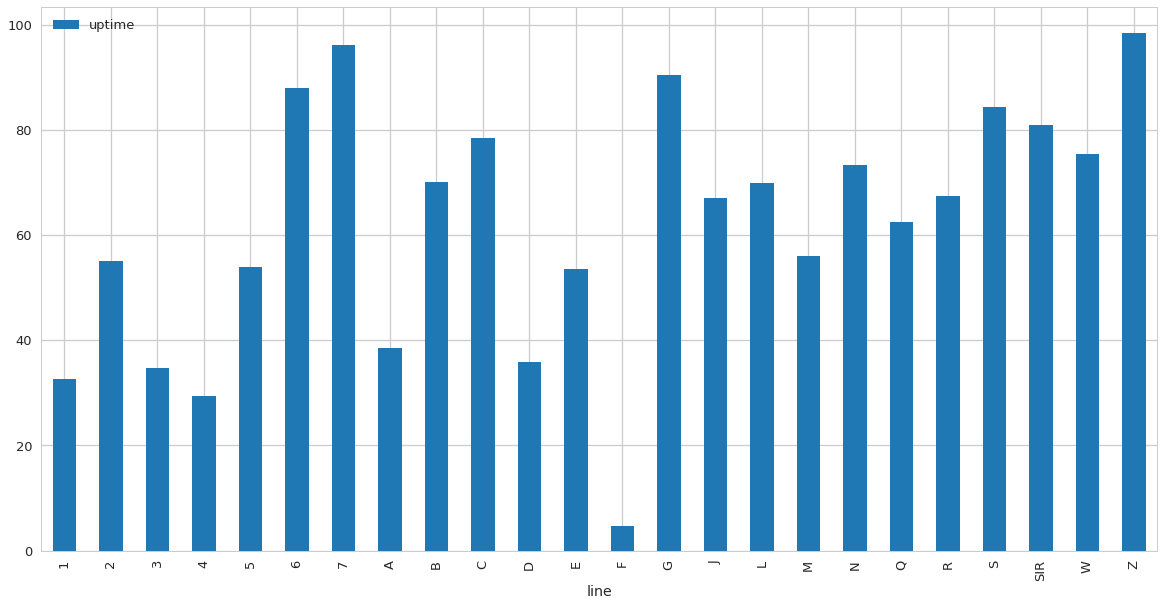

In [5]:
dfl.plot(kind='bar',figsize=(20,10))